# LAGO (Linear Approximation for Graph Optimization)

The `gtsam::lago` namespace provides functions for initializing `Pose2` estimates in a 2D SLAM factor graph.
LAGO stands for **Linear Approximation for Graph Optimization**. It leverages the structure of typical 2D SLAM problems to efficiently compute an initial guess, particularly for the orientations, which are often the most challenging part for nonlinear solvers.

The core idea is:
1.  **Estimate Orientations:** Assume orientations are independent of translations and solve a linear system just for the orientations ($\theta$). This exploits the fact that the orientation part of the `Pose2` `BetweenFactor` error is approximately linear for small errors.
2.  **Estimate Translations:** Given the estimated orientations, compute the translations by solving another linear system.

Key functions:
*   `initializeOrientations(graph)`: Computes initial estimates for the `Rot2` (orientation) components of the poses in the graph.
*   `initialize(graph)`: Computes initial estimates for the full `Pose2` variables (orientations and translations).
*   `initialize(graph, initialGuess)`: Corrects only the orientation part of a given `initialGuess` using LAGO.

LAGO typically assumes the graph contains a spanning tree of odometry measurements and a prior on the starting pose.

**Important Note**: LAGO expects integer keys numbered from 0 to n-1, with n the number of poses.

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/slam/doc/lago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass  # Not running on Colab, do nothing

In [2]:
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from gtsam import NonlinearFactorGraph, Pose2, PriorFactorPose2, BetweenFactorPose2
from gtsam import lago

## Example Initialization

We'll create a simple 2D pose graph with odometry and a loop closure, then use `lago.initialize`.

In [8]:
# 1. Create a NonlinearFactorGraph with Pose2 factors
graph = NonlinearFactorGraph()

# Add a prior on the first pose
prior_mean = Pose2(0.0, 0.0, 0.0)
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.05]))
graph.add(PriorFactorPose2(0, prior_mean, prior_noise))

# Add odometry factors (simulating moving in a square)
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
graph.add(BetweenFactorPose2(0, 1, Pose2(2.0, 0.0, 0.0), odometry_noise))
graph.add(BetweenFactorPose2(1, 2, Pose2(2.0, 0.0, np.pi/2), odometry_noise))
graph.add(BetweenFactorPose2(2, 3, Pose2(2.0, 0.0, np.pi/2), odometry_noise))
graph.add(BetweenFactorPose2(3, 4, Pose2(2.0, 0.0, np.pi/2), odometry_noise))

# Add a loop closure factor
loop_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.25, 0.25, 0.15]))
# Ideal loop closure would be Pose2(2.0, 0.0, np.pi/2)
measured_loop = Pose2(2.1, 0.1, np.pi/2 + 0.05)
graph.add(BetweenFactorPose2(4, 0, measured_loop, loop_noise))

# 2. Perform LAGO initialization
initial_estimate_lago = lago.initialize(graph)

print("\nInitial Estimate from LAGO:\n")
initial_estimate_lago.print()


Initial Estimate from LAGO:

Values with 5 values:
Value 0: (gtsam::Pose2)
(-7.47244713e-17, -6.32592437e-17, -0.00193783525)

Value 1: (gtsam::Pose2)
(1.70434147, -0.00881225307, 0.034656973)

Value 2: (gtsam::Pose2)
(3.40930145, 0.0555625509, 1.64569894)

Value 3: (gtsam::Pose2)
(2.9638596, 2.05327873, 3.10897006)

Value 4: (gtsam::Pose2)
(0.669190885, 2.11357777, -1.71695927)



The block below visualizes the initial estimate computed by the LAGO algorithm. It uses the `gtsam_plot.plot_pose2` function to plot the poses in 2D space. Each pose is represented with its position and orientation, providing an intuitive way to inspect the initialization results. The visualization helps verify the correctness of the initial guess before proceeding with further optimization.

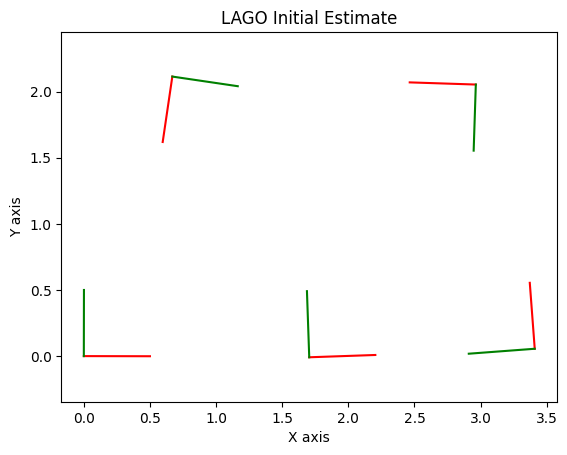

In [ ]:
plt.figure(1)
for key in initial_estimate_lago.keys():
    gtsam_plot.plot_pose2(1, initial_estimate_lago.atPose2(key), 0.5)
plt.title("LAGO Initial Estimate")
plt.axis('equal')
plt.show()

Finally, let's look at `lago.initializeOrientations` to compute the initial orientation estimatesThis solves a linear system, and the solution is represented as a `VectorValues` object, which stores the estimated angles for each pose as a 1-d vector.

We compare these orientation estimates with the orientations extracted from the full LAGO initialization (`lago.initialize`).

In [ ]:
initial_orientations = lago.initializeOrientations(graph)
print("\nLAGO Orientations (VectorValues):")
initial_orientations.print()

print("Orientations from full LAGO Values:")
for i in range(5):
    print(f" {i}: {initial_estimate_lago.atPose2(i).theta():.4f}")


LAGO Orientations (VectorValues):
VectorValues: 6 elements
  0: -1.11022302e-16
  1: -0.008
  2: 1.55479633
  3: 3.11759265
  4: 4.68038898
  99999999: 0
Orientations from full LAGO Values:
 0: -0.0019
 1: 0.0347
 2: 1.6457
 3: 3.1090
 4: -1.7170


These are not as accurate (the last one is actually fine, it's $2\pi$ off) but will still be good enough as an initial estimate.